In [1]:
import kernel
import numpy as np
import scipy
import matplotlib as plt
import sklearn
import johnson
import matplotlib.pyplot as plt
import time
import PyRKHSstats
from PyRKHSstats import mmd, kernel_wrapper
import warnings
import tensorflow as tf

warnings.filterwarnings("ignore")

seed = 1048596

2025-05-30 16:03:28.364887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748621008.584628    3000 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748621008.666755    3000 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748621008.972026    3000 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748621008.972066    3000 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748621008.972069    3000 computation_placer.cc:177] computation placer alr

# I. Goodness of fit of the Johnson's approximation

In [2]:
rng = np.random.default_rng(seed)

MMDs = []
n_MMD = 1_000
n = 1_000
m = 10_000

for k in range(n_MMD):
    X = rng.multivariate_normal(np.zeros(2), np.eye(2), n)
    Y = rng.multivariate_normal(np.zeros(2), np.eye(2), n)
    mmd = rbf.MMD_2_U(X, Y)
    MMDs.append(mmd)

MMDs = np.array(MMDs)

X = rng.multivariate_normal(np.zeros(2), np.eye(2), m)
Y = rng.multivariate_normal(np.zeros(2), np.eye(2), m)
moments = rbf.moments_MMD_2_U(X, Y)
distrib = johnson.fit_johnsonsu_by_moments(*moments)

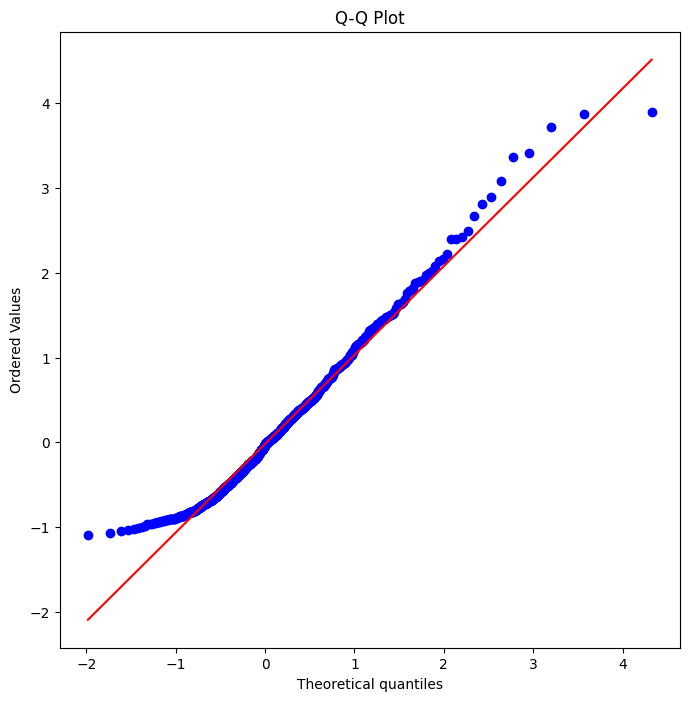

In [3]:
plt.figure(figsize=(8, 8))
scipy.stats.probplot(MMDs, dist=distrib, plot=plt)
plt.title('Q-Q Plot')
plt.show()

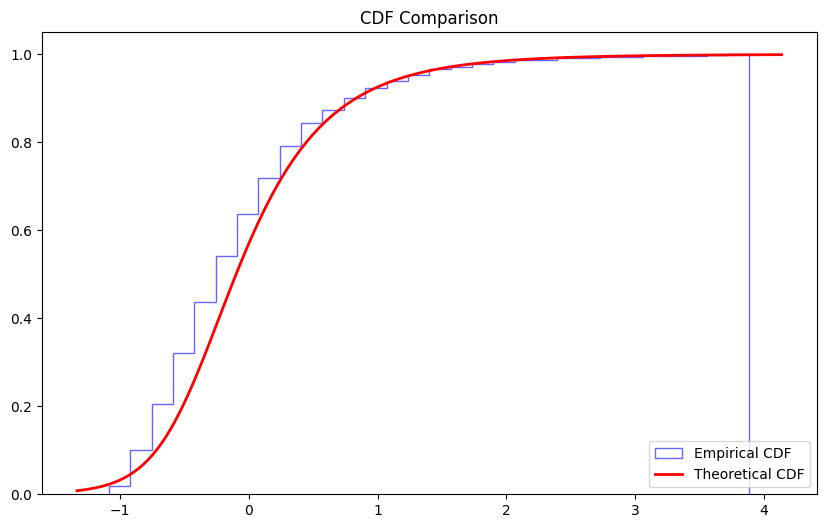

In [4]:
plt.figure(figsize=(10, 6))

# Empirical CDF
plt.hist(MMDs, bins=30, density=True, cumulative=True, 
         alpha=0.6, color='b', histtype='step', label='Empirical CDF')

# Theoretical CDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
plt.plot(x, distrib.cdf(x), 'r-', lw=2, label='Theoretical CDF')

plt.title('CDF Comparison')
plt.legend(loc='lower right')
plt.show()

In [5]:
ks_statistic, p_value = scipy.stats.kstest(MMDs, distrib.cdf)
print(p_value)

0.00020792834508669622


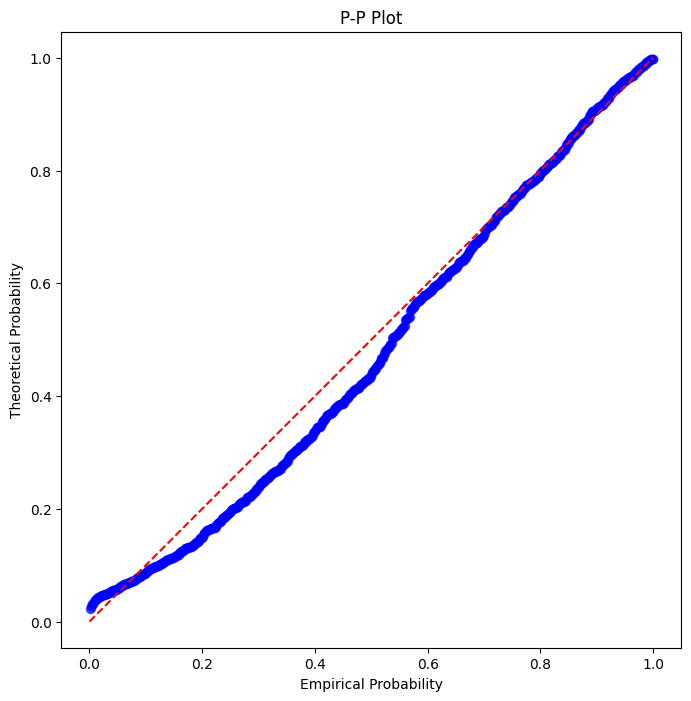

In [6]:
plt.figure(figsize=(8, 8))

# Calculate empirical and theoretical CDF values
sample_sorted = np.sort(MMDs)
ecdf = np.arange(1, len(MMDs)+1) / len(MMDs)
tcdf = distrib.cdf(sample_sorted)

# Plot
plt.plot(ecdf, tcdf, 'bo', alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')  # Reference line
plt.xlabel('Empirical Probability')
plt.ylabel('Theoretical Probability')
plt.title('P-P Plot')
plt.axis('equal')
plt.show()

# II. Synthetic data

In [12]:
def wilson_interval(k, n, confidence=0.95):
    p_hat = k / n
    z = scipy.stats.norm.ppf(1 - (1 - confidence)/2)
    center = (p_hat + z**2/(2*n)) / (1 + z**2/n)
    margin = z * np.sqrt((p_hat*(1 - p_hat)/n + z**2/(4*n**2)) / (1 + z**2/n))
    lower = np.maximum(0, center - margin)
    upper = np.minimum(1, center + margin)
    return center, lower, upper

In [41]:
def plot(X, xlabel, results, ylabel, test_names, title, xlog=False, ylog=False, ic=False):

    plt.figure(figsize=(15, 5))
    colors = plt.cm.tab10.colors
    markers = ["o", "x", "v", "^", "h"]

    if ic:
        ics = np.zeros((results.shape[0], results.shape[1], 3))  # Center, lower, upper
        for i in range(results.shape[0]):
            for k in range(results.shape[2]):
                rejections = results[i, :, k].sum()
                center, lower, upper = wilson_interval(rejections, results.shape[1])
                ics[i, k] = [center, lower, upper]
        
        for k in range(results.shape[2]):
            center = ics[:, k, 0]
            lower = ics[:, k, 1]
            upper = ics[:, k, 2]
            
            plt.plot(X, center, color=colors[k], label=test_names[k], marker=markers[k], linestyle="-")
            plt.fill_between(X, lower, upper, color=colors[k], alpha=0.2)
    
    else:
        avg = results.mean(axis=1)
        for k in range(results.shape[1]):
            plt.plot(X, avg[:, k], 
                    color=colors[k],
                    marker='o',
                    linestyle='-',
                    label=test_names[k])

    plt.xlabel(xlabel)
    if xlog:
        plt.xscale('log')
    plt.ylabel(ylabel)
    if ylog:
        plt.yscale('log')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [16]:
P = 200
alpha = 0.05
rbf = kernel.GaussianKernel()
wrapped_rbf = kernel_wrapper.KernelWrapper(rbf)

## A) One-dimensional gaussians

In [ ]:
rng = np.random.default_rng(seed)
np.random.seed(seed)

sigma_min, sigma_max = 0.505, 0.66
n_sigma = 10
sigmas = np.linspace(sigma_min, sigma_max, n_sigma)
n_rep = 5
n = 500


tests = [lambda X, Y, rng: rbf.test_MMD_2_U_M(X, Y, alpha),
lambda X, Y, rng: int(mmd.perform_permutation_mmd(X, Y, wrapped_rbf, alpha, P)['Reject H0 (H0 : P_X = P_Y)']),
lambda X, Y, rng: int(mmd.perform_gram_matrix_spectrum_mmd(X, Y, wrapped_rbf, alpha, P)['Reject H0 (H0 : P_X = P_Y)']),
lambda X, Y, rng: rbf.test_mmd_nystrom_uniform(X, int(np.sqrt(X.shape[0]) / 2), Y, int(np.sqrt(Y.shape[0]) / 2), alpha, P, rng),
lambda X, Y, rng: int(scipy.stats.ks_2samp(X, Y).pvalue[0] <= alpha),
]
test_names = ["Moments MMD²", "Permuation MMD²", "Gram MMD²", "Nyström MMD", "KS"]

results = np.zeros((n_sigma, n_rep, len(tests)))

for i, sigma in enumerate(sigmas):
    for j in range(n_rep):
        X = rng.normal(0, 0.5, n).reshape(-1, 1)
        Y = rng.normal(0, sigma, n).reshape(-1, 1)
        rbf.fit_bandwidth(X, Y, 500)
        for k in range(len(tests)):
            results[i, j, k] = tests[k](X, Y, rng)

0


/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5916: RuntimeWarning: overflow encountered in multiply
  g1 = -t1 * (t2 + t3) / denom
/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5919: RuntimeWarning: overflow encountered in multiply
  t2 = 4*expbn2**2 * (expbn2 + 2) * np.cosh(2*a_b)
/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5920: RuntimeWarning: overflow encountered in multiply
  t3 = expbn2**2 * np.cosh(4*a_b)
/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5921: RuntimeWarning: overflow encountered in power
  t4 = -3 + 3*expbn2**2 + 2*expbn2**3 + expbn2**4
/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5922: RuntimeWarning: overflow encountered in square
  denom = 2*(1 + expbn2*np.cosh(2*a_b))**2
/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5923: RuntimeWarning: invalid value encountered in divide
  g2 = (t1 + t2 + t

1
2


/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5910: RuntimeWarning: overflow encountered in multiply
  mu2 = 0.5*sc.expm1(bn2)*(expbn2*np.cosh(2*a_b) + 1)
/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5914: RuntimeWarning: overflow encountered in multiply
  t3 = expbn2 * (expbn2 + 2) * np.sinh(3*a_b)
/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5919: RuntimeWarning: overflow encountered in square
  t2 = 4*expbn2**2 * (expbn2 + 2) * np.cosh(2*a_b)
/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5920: RuntimeWarning: overflow encountered in square
  t3 = expbn2**2 * np.cosh(4*a_b)
/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5921: RuntimeWarning: overflow encountered in square
  t4 = -3 + 3*expbn2**2 + 2*expbn2**3 + expbn2**4


3


/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5904: RuntimeWarning: overflow encountered in exp
  expbn2 = np.exp(bn2)
/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5916: RuntimeWarning: invalid value encountered in divide
  g1 = -t1 * (t2 + t3) / denom


4
5
6
7
8
9


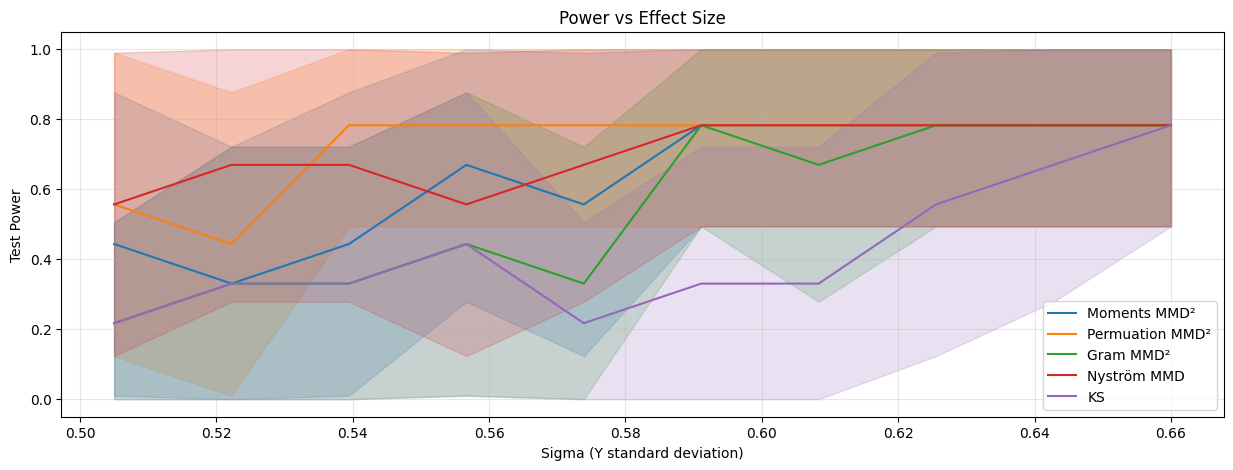

In [ ]:
power_plot(sigmas, "$\sigma_2^2$", results, "Power ($\alpha=0.05$)", "", test_names, ic=True)


In [ ]:
rng = np.random.default_rng(seed)
np.random.seed(seed)

sigma = 0.6
n_rep = 5
n_sizes = 10
sample_sizes = np.exp(np.linspace(np.log(100), np.log(2000), n_sizes)).astype(int)
times = np.zeros((n_sizes, n_rep, len(tests)))

for i, n in enumerate(sample_sizes):
    for j in range(n_rep):
        X = rng.normal(0, 0.5, n).reshape(-1, 1)
        Y = rng.normal(0, sigma, n).reshape(-1, 1)
        for k in range(len(tests)):
            t = time.perf_counter()
            tests[k](X, Y, rng)
            times[i, j, k] = time.perf_counter() - t

0
1
2


/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5910: RuntimeWarning: overflow encountered in multiply
  mu2 = 0.5*sc.expm1(bn2)*(expbn2*np.cosh(2*a_b) + 1)
/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5914: RuntimeWarning: overflow encountered in multiply
  t3 = expbn2 * (expbn2 + 2) * np.sinh(3*a_b)
/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5920: RuntimeWarning: overflow encountered in multiply
  t3 = expbn2**2 * np.cosh(4*a_b)
/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5922: RuntimeWarning: overflow encountered in square
  denom = 2*(1 + expbn2*np.cosh(2*a_b))**2


3
4
5
6
7


/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5915: RuntimeWarning: overflow encountered in power
  denom = np.sqrt(2) * (1 + expbn2 * np.cosh(2*a_b))**(3/2)
/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5919: RuntimeWarning: overflow encountered in square
  t2 = 4*expbn2**2 * (expbn2 + 2) * np.cosh(2*a_b)
/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5920: RuntimeWarning: overflow encountered in square
  t3 = expbn2**2 * np.cosh(4*a_b)
/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5921: RuntimeWarning: overflow encountered in square
  t4 = -3 + 3*expbn2**2 + 2*expbn2**3 + expbn2**4


8


/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5914: RuntimeWarning: overflow encountered in sinh
  t3 = expbn2 * (expbn2 + 2) * np.sinh(3*a_b)
/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5920: RuntimeWarning: overflow encountered in cosh
  t3 = expbn2**2 * np.cosh(4*a_b)


9


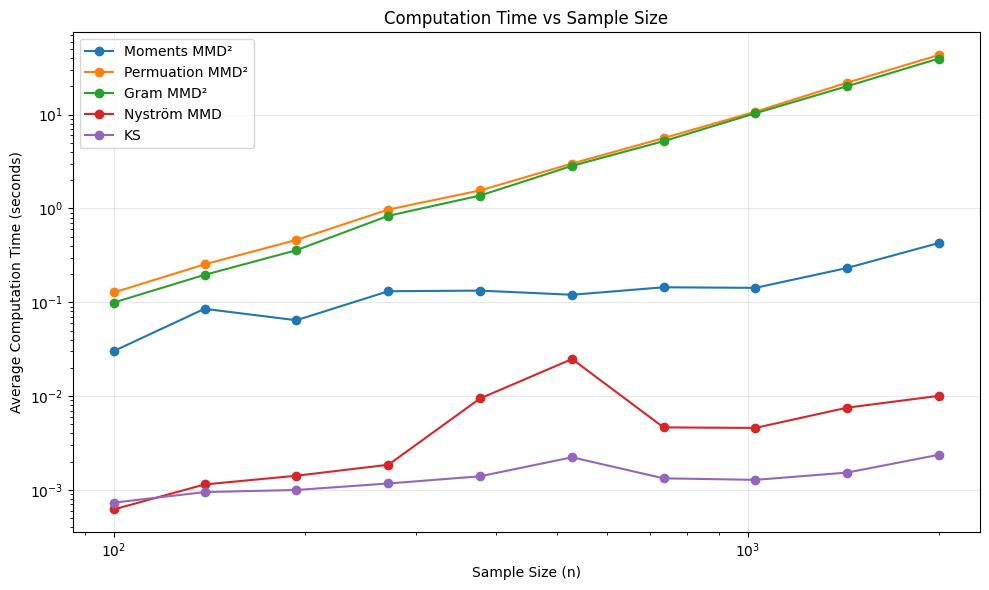

In [ ]:
power_plot(sample_sizes, "Sample size", times, "Computation time (s)", "", test_names, xlog=True, ylog=True)

In [30]:
rng = np.random.default_rng(seed)

n = 1000
n_rep = 500
rejections = 0
for k in range(n_rep):
    X = rng.normal(0, 1, n).reshape(-1, 1)
    Y = rng.normal(0, 1, n).reshape(-1, 1)
    rejections += rbf.test_MMD_2_U_M(X, Y, alpha)

print(wilson_interval(rejections, n_rep))

/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5904: RuntimeWarning: overflow encountered in exp
  expbn2 = np.exp(bn2)
/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5914: RuntimeWarning: overflow encountered in sinh
  t3 = expbn2 * (expbn2 + 2) * np.sinh(3*a_b)
/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5915: RuntimeWarning: overflow encountered in cosh
  denom = np.sqrt(2) * (1 + expbn2 * np.cosh(2*a_b))**(3/2)
/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5916: RuntimeWarning: invalid value encountered in divide
  g1 = -t1 * (t2 + t3) / denom
/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5919: RuntimeWarning: overflow encountered in cosh
  t2 = 4*expbn2**2 * (expbn2 + 2) * np.cosh(2*a_b)
/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5920: RuntimeWarning: overflow encountered in cosh
  t3 = expbn2**2 * np.cosh(4*a_b)

(np.float64(0.08320222299385195), np.float64(0.059206478518440325), np.float64(0.10719796746926358))


## B) Multidimensional gaussians

In [ ]:
rng = np.random.default_rng(seed)

sigma_min, sigma_max = 0.505, 0.66
sigmas = np.linspace(sigma_min, sigma_max, n_sigma)
n_sigma = 10
n_rep = 100
n = 500


tests = [lambda X, Y, rng: rbf.test_MMD_2_U_M(X, Y, alpha),
lambda X, Y, rng: rbf.test_mmd_nystrom_uniform(X, int(np.sqrt(X.shape[0]) / 2), Y, int(np.sqrt(Y.shape[0]) / 2), alpha, P, rng)]
test_names = ["Moments MMD²", 
"Nyström MMD"]

results = np.zeros((n_sigma, n_rep, len(tests)))

for i, sigma in enumerate(sigmas):
    for j in range(n_rep):
        X = rng.multivariate_normal(np.zeros(3), np.eye(3) + 0.5 * (1 - np.eye(3)), n)
        Y = rng.multivariate_normal(np.zeros(3), np.eye(3) + sigma * (1 - np.eye(3)), n)
        rbf.fit_bandwidth(X, Y, 500)
        for k in range(len(tests)):
            results[i, j, k] = tests[k](X, Y, rng)

/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5904: RuntimeWarning: overflow encountered in exp
  expbn2 = np.exp(bn2)
/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5916: RuntimeWarning: invalid value encountered in divide
  g1 = -t1 * (t2 + t3) / denom
/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5920: RuntimeWarning: overflow encountered in cosh
  t3 = expbn2**2 * np.cosh(4*a_b)
/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5923: RuntimeWarning: invalid value encountered in divide
  g2 = (t1 + t2 + t3*t4) / denom - 3
/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5922: RuntimeWarning: overflow encountered in square
  denom = 2*(1 + expbn2*np.cosh(2*a_b))**2
/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5921: RuntimeWarning: overflow encountered in power
  t4 = -3 + 3*expbn2**2 + 2*expbn2**3 + expbn2**4
/usr/local/lib/p

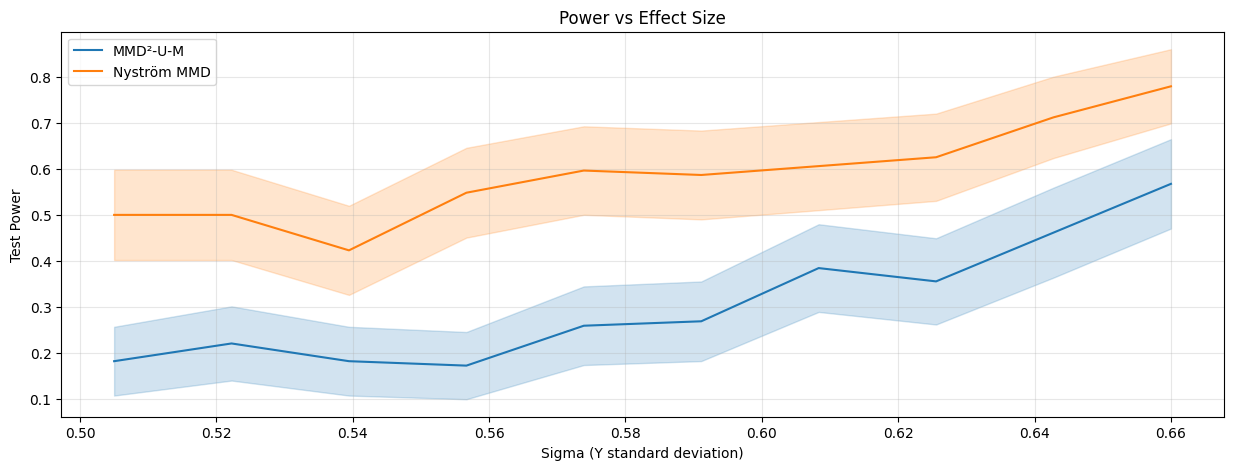

In [ ]:
power_plot(sigmas, "$\rho_2$", results, "Power ($\alpha=0.05$)", "", test_names, ic=True)

In [ ]:
rng = np.random.default_rng(seed)

n_rep = 20
n = 500
n_dims = 25
dims = np.exp(np.linspace(np.log(10), np.log(10_000), n_dims)).astype(int)

tests = [lambda X, Y, rng: rbf.test_MMD_2_U_M(X, Y, alpha),
lambda X, Y, rng: rbf.test_mmd_nystrom_uniform(X, int(np.sqrt(X.shape[0]) / 2), Y, int(np.sqrt(Y.shape[0]) / 2), alpha, P, rng)]
test_names = ["Moments MMD²",
 "Nyström MMD"]

results = np.zeros((n_dims, n_rep, len(tests)))

for i, dim in enumerate(dims):
    for j in range(n_rep):
        X = rng.multivariate_normal(np.zeros(dim), 0.5 * np.eye(dim), n)
        Y = rng.multivariate_normal(np.ones(dim) / np.sqrt(dim), 0.5 * np.eye(dim), n)
        rbf.fit_bandwidth(X, Y, 500)
        for k in range(len(tests)):
            results[i, j, k] = tests[k](X, Y, rng)

/usr/local/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5918: RuntimeWarning: overflow encountered in multiply
  t1 = 3 + 6*expbn2
/usr/local/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:619: RuntimeWarning: overflow encountered in divide
  J_transposed[i] = df / dx


KeyboardInterrupt: 

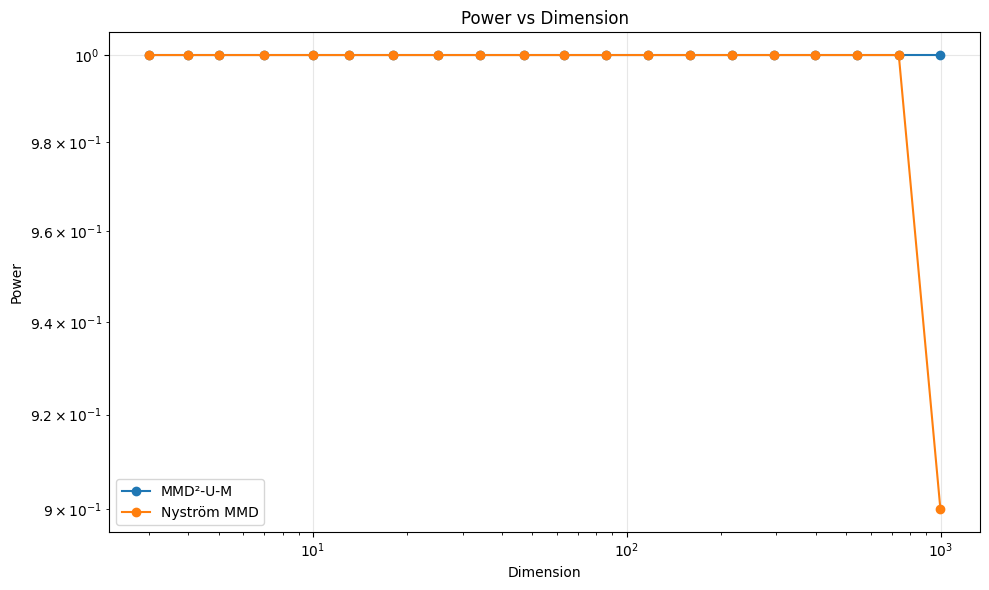

In [ ]:
plot(dims, "Dimension", results, "Power ($\alpha=0.05$)", "", test_names, ic=True)

# II. Higgs Dataset

In [ ]:
import tensorflow as tf

gz = tf.keras.utils.get_file(
    'HIGGS.csv.gz', 
    'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz'
)

2816407858/2816407858 ━━━━━━━━━━━━━━━━━━━━ 325s 0us/step


I0000 00:00:1748621356.096800    3000 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13764 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:3b:00.0, compute capability: 7.5


In [3]:
ds = tf.data.experimental.CsvDataset(
    filenames=gz,
    record_defaults=record_defaults,
    compression_type="GZIP",
    header=False  # No header row
)
def pack_features(*row):
    label = row[0]
    features = tf.stack(row[1:], axis=0)
    return features, label

packed_ds = ds.map(pack_features)

bg_ds = np.array(list(packed_ds.filter(lambda features, label: label == 0).map(lambda features, label: features[:14]).take(200_000)))
sg_ds = np.array(list(packed_ds.filter(lambda features, label: label == 1).map(lambda features, label: features[:14]).take(200_000)))

Cause: could not parse the source code of <function <lambda> at 0x7fb52250a0c0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda features, label: features[:14]

Match 1:
lambda features, label: label == 0

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fb52250a0c0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda features, label: features[:14]

Match 1:
lambda features, label: label == 0

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 

2025-05-30 16:09:41.958415: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Cause: could not parse the source code of <function <lambda> at 0x7fb36845fa60>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda features, label: features[:14]

Match 1:
lambda features, label: label == 1

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fb36845fa60>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda features, label: features[:14]

Match 1:
lambda features, label: label == 1

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 

2025-05-30 16:10:06.393729: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
def generate_samples(bg_data, sg_data, n, alpha_mix, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    
    # Calculate sizes for each component
    n_bg = int((1 - alpha_mix) * n)
    n_sg = n - n_bg
    

    # Sample from bg and sg
    bg_samples = rng.choice(bg_data, size=n_bg + n, replace=False)
    P_sample, bg_sample = bg_samples[:n], bg_samples[n:]
    sg_sample = rng.choice(sg_data, size=n_sg, replace=False)
    
    # Combine into Q sample
    Q_sample = np.vstack([bg_sample, sg_sample])
    
    # Shuffle to mix events
    rng.shuffle(P_sample, axis=0)
    rng.shuffle(Q_sample, axis=0)
    return P_sample, Q_sample

In [ ]:
rng = np.random.default_rng(seed)

rbf = kernel.GaussianKernel()

alpha = 0.95
P = 200
n_rep = 20
n_min, n_max = 1000, 80_000
n_samples = 8
sample_sizes = np.linspace(n_min, n_max, n_samples).astype(int)
alpha_mix = 0.2

tests = [lambda X, Y, rng: rbf.test_mmd_nystrom_uniform(X, int(np.sqrt(X.shape[0]) / 2), Y, int(np.sqrt(Y.shape[0]) / 2), alpha, P, rng)]
test_names = ["Nyström MMD"]

results = np.zeros((n_samples, n_rep, len(tests)))

for i, n in enumerate(sample_sizes):
    for j in range(n_rep):
        X, Y = generate_samples(bg_ds, sg_ds, n, alpha_mix)
        rbf.fit_bandwidth(X, Y, min(n, 2000))
        for k in range(len(tests)):
            results[i, j, k] = tests[k](X, Y, rng)

0 1000
1 12285
2 23571
3 34857
4 46142
5 57428
6 68714
7 80000


(8, 20, 1) 10 5
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) o


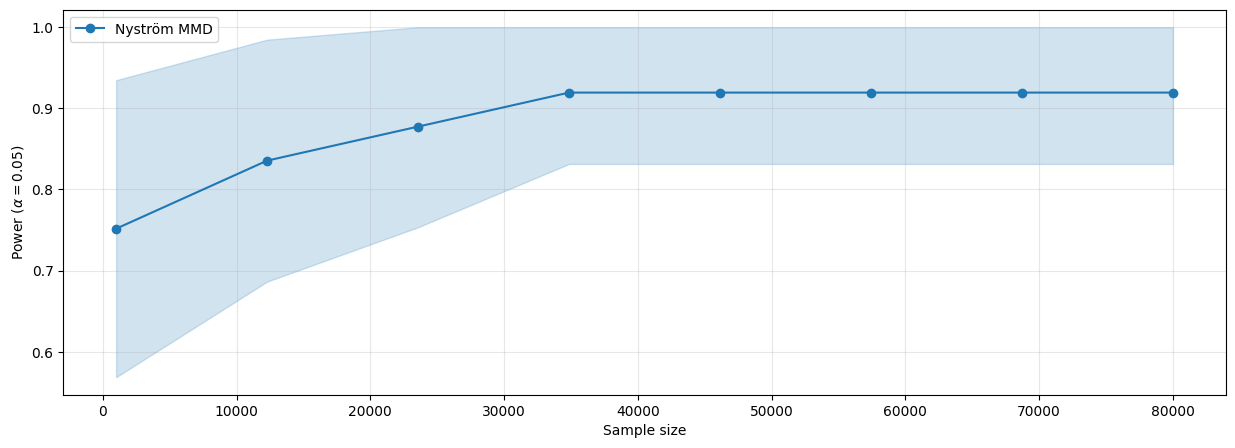

In [25]:
plot(sample_sizes, "Sample size", results, r"Power ($\alpha=0.05$)", test_names, "", ic=True)

In [ ]:
rng = np.random.default_rng(seed)

n_rep = 100
n = 16_000
l_min, l_max = 10, 1000
n_features = 10
features_lengths = np.exp(np.linspace(np.log(l_min), np.log(l_max), n_features)).astype(int)
alpha_mix = 0.2

tests = [lambda X, Y, rng: rbf.test_mmd_nystrom_uniform(X, int(np.sqrt(X.shape[0]) / 2), Y, int(np.sqrt(Y.shape[0]) / 2), alpha, P, rng)]
test_names = ["Nyström MMD"]

results = np.zeros((n_features, n_rep, len(tests)))

X, Y = generate_samples(bg_ds, sg_ds, n, alpha_mix)
rbf.fit_bandwidth(X, Y, 2000)

for i, n in enumerate(features_lengths):
    for j in range(n_rep):
        for k in range(len(tests)):
            results[i, j, k] = rbf.test_mmd_nystrom_uniform(X, int(i / 2), Y, int(i / 2), alpha, P, rng)

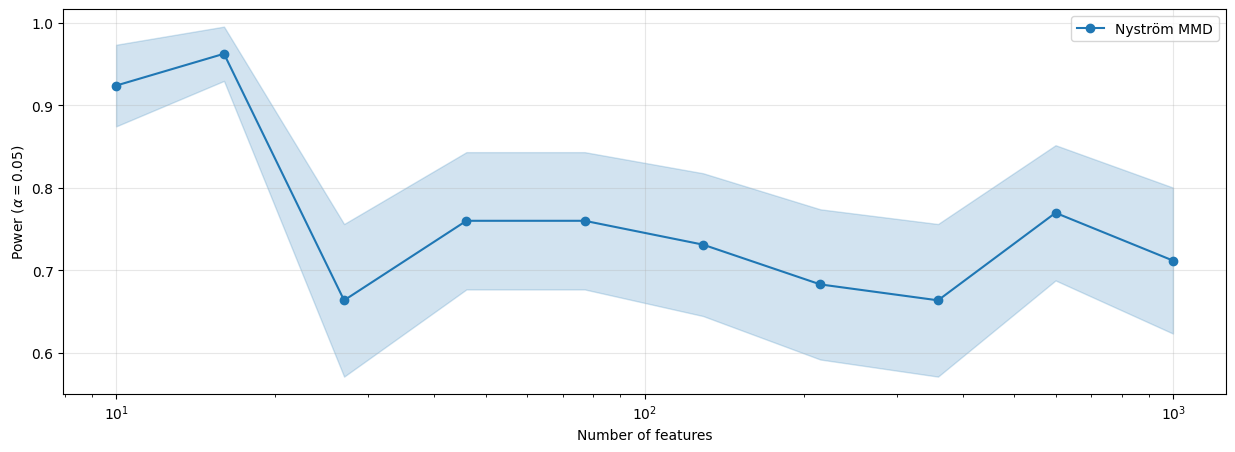

In [43]:
plot(features_lengths, "Number of features", results, r"Power ($\alpha=0.05$)", test_names, "", xlog=True, ic=True)